<a href="https://colab.research.google.com/github/HwangJae-won/Pytorch_study/blob/main/image_segmentation_%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Torchvision을 활용한 이미지 segmentation
- 보행자 감지 및 분할  task
- Pretrained Mask R-CNN 활용하여 Finetuning 진행
- Pretrained Dataset: 345개의 객체 포함 (객체별 다른 라벨 가짐), 170개의 이미지

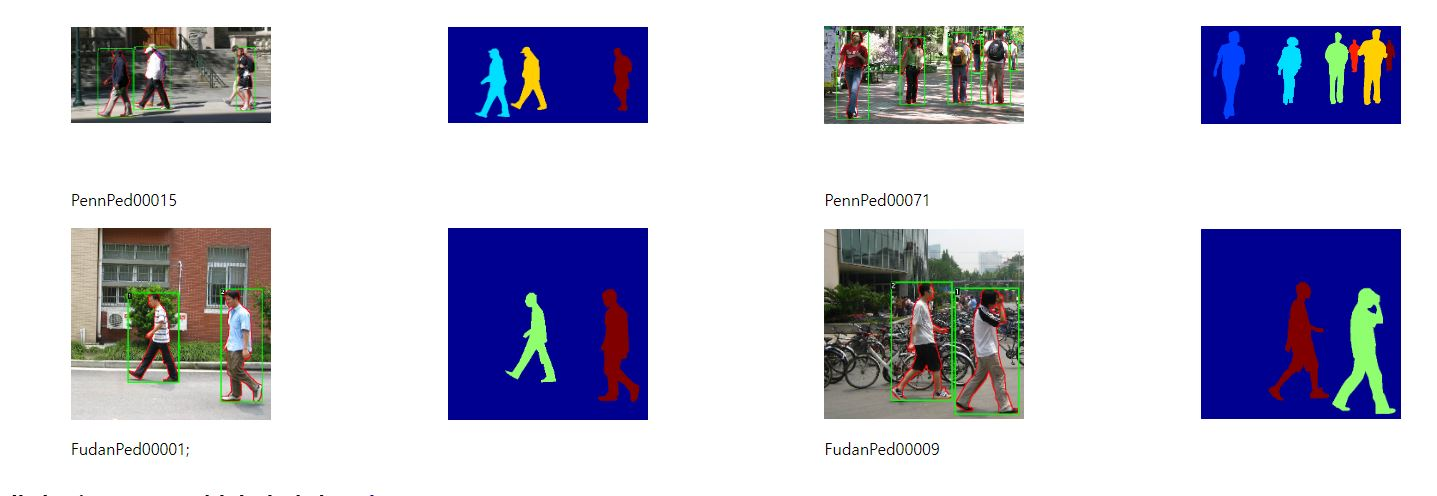

In [ ]:
%%shell
pip install cython #파이썬에서 C 언어를 사용하기 위한 패키지

# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' # COCO 데이터셋을 활용하기 위해서 API 받아옴

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3rmisv0z
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3rmisv0z
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265173 sha256=5481730751f33659e9c64919390ecbe33ac6222fbb0e4e81f1e02b1944f36fa8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8j_d2_w6/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


## Dataset 정의하기
- 다른 task의 Dataset 정의하는 과정과 다르게, 이미지 segmentation을 수행할 때는 torchvision을 활용하여 추가해야하는 요소들이 있음. 
- Dataset 정의시에 __getitem__ 에 다음과 같은 요소들 포함
  - 이미지 : PIL(Python Image Library) 이미지의 크기 (H, W) -> Height , Width
  - **boxes** (FloatTensor[N, 4]): N 개의 Bounding box의 좌표를 [x0, y0, x1, y1] 형태로 가짐. x와 관련된 값 범위는 0 부터 W 이고 y와 관련된 값의 범위는 0 부터 H 까지 
  - **labels** (Int64Tensor[N]): 바운딩 박스 마다의 라벨 정보입니다. 0 은 항상 배경의 클래스를 표현. 객체마다 라벨링 다르게 되어 있음. 

  - **image_id **(Int64Tensor[1]): 이미지마다 가지고 있는 번호. 데이터셋의 모든 이미지 간에 고유한 값이어야 하며 평가 중에도 사용됨. 

  - **area** (Tensor[N]): 바운딩 박스의 면적입니다. 면적은 평가 시 작음,중간,큰 박스 간의 점수를 내기 위한 기준이며 COCO 평가를 기준으로 함.

  - **iscrowd** (UInt8Tensor[N]): 이 값이 참일 경우 평가에서 제외함. 훈련시에만 사용.

  -(선택적) masks (UInt8Tensor[N, H, W]): N 개의 객체 마다의 분할 마스크 정보입니다.

  - (선택적) keypoints (FloatTensor[N, K, 3]): N 개의 객체마다의 키포인트 정보입니다. 키포인트는 [x, y, visibility] 형태의 값입니다. visibility 값이 0인 경우 키포인트는 보이지 않음을 의미합니다. 데이터 증강(Data augmentation)의 경우 키포인트 좌우 반전의 개념은 데이터 표현에 따라 달라지며, 새로운 키포인트 표현에 대해 “references/detection/transforms.py” 코드 부분을 수정 해야 할 수도 있습니다.


배경은 0으로 라벨링 함. 배경클래스가 없을 경우 라벨에 0이 있으면 안됨. 


### Penn-Fudan 데이터를 커스터마이징하기
해당 링크에서 다운로드 가능
 https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .

# extract it in the current folder
unzip PennFudanPed.zip #폴더 unzip : 같은 폴더 내에 바로 해제 가능.

--2022-07-08 04:31:03--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  13.7MB/s    in 4.5s    

2022-07-08 04:31:08 (11.5 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-07-08 04:31:08--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-07-08 04:31:08--
Total wall clock time: 5.3s
Downloaded: 1 files, 51M in 4.5s (11.5 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

데이터 구조
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```
이미지와 그에 해당하는 mask 포함되어 있음. 

- 데이터 예시 확인해보기

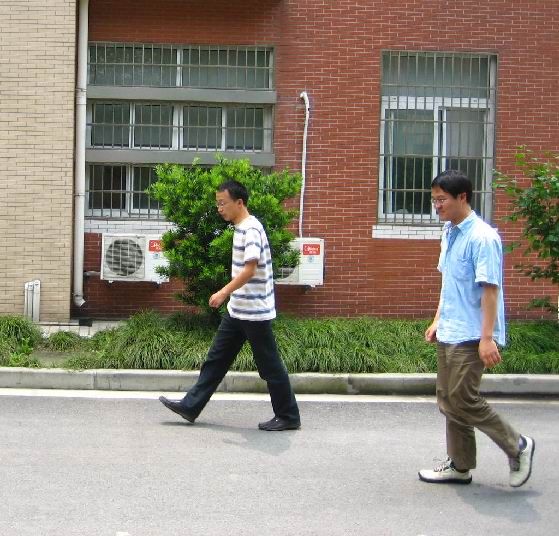

In [ ]:
#원본 이미지
from PIL import Image #이미지 파일 읽을 수 있는 라이브러리
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

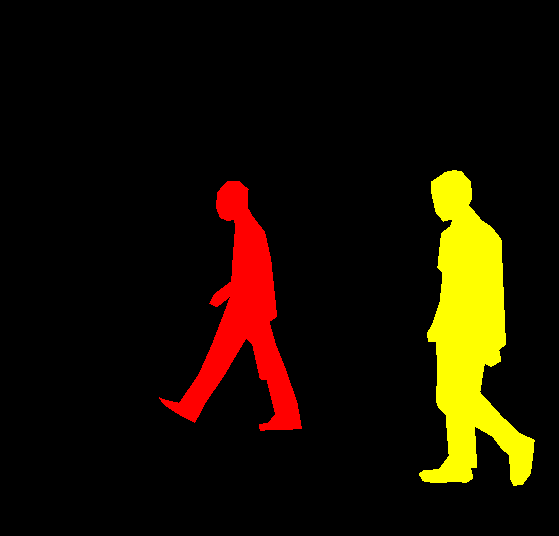

In [ ]:
# 객체마다 다른 색 가짐 (0~ N)
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')

#라벨별 색상 확인
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask # 다른 사람마다 다른 색으로 색칠됨.

커스터마이징 Dataset 정의하기 : torch.utils.data 활용

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        #데이터셋 불러오되, 정렬해서 불러오기 -> 번호별로 차례대로 불러오기 위해서 
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 경로 지정 후 데이터 불러옴, RGB로 변환해서 불러오기 
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path) #mask 는 RGB로 변환할 필요 없음 (객체마다 대응되는 색상 존재 , 배경 0 )
      

        mask = np.array(mask)
        # 각자 다른 색상으로 인코딩
        obj_ids = np.unique(mask)
        # 첫번째 id는 배경이라서 지움
        obj_ids = obj_ids[1:]

        # a set of binary masks으로 나눔 : 왜...?
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        #데이터셋에 boxed, labels, masks, image_id, area, iscrowd 포함되어 있음. 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

데이터셋 구조 확인해보기:  boxed, labels, masks, image_id, area, iscrowd 포함되어 있음. 
-> dictionary


In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F463B527910>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

기본적으로 PIL로 반환되는 거 확인할 수 있음.

## 모델 정의하기 
Pretrained model 활용: Mask R-CNN (Faster R-CNN 에 기반함)

- Fast R-CNN: 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델 (클래스 점수 : 어떤 클래스에 속할 지에 대한 확률)

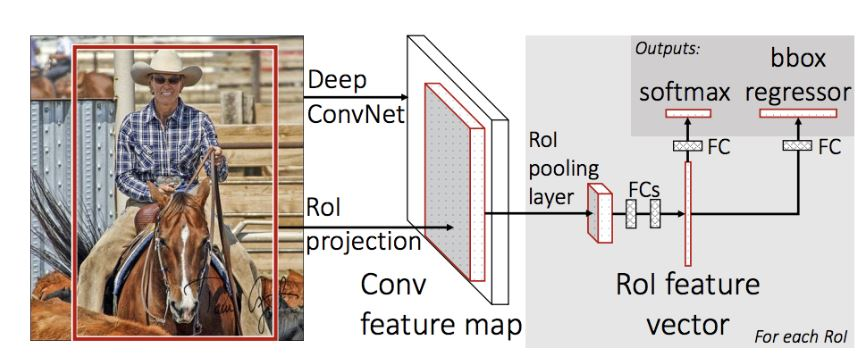

- Mask R-CNN:  각 인스턴스에 대한 분할 마스크 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델

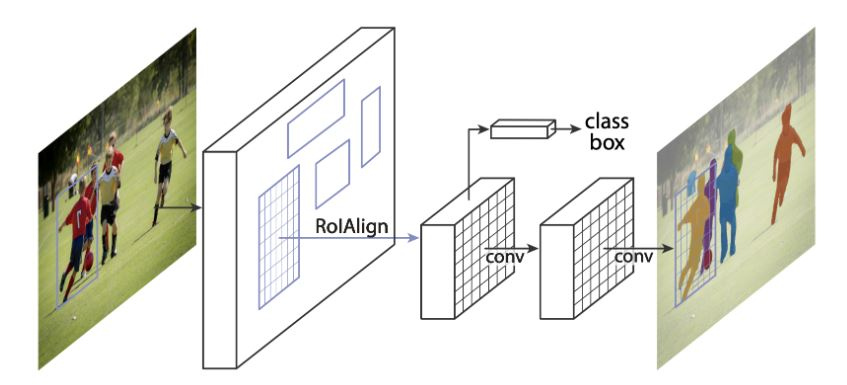

- Torchvision model zoo (미리 학습된 모델들을 모아 놓은 공간)에서 사용 가능한 모델들 중 하나를 이용해 모델을 수정
  -  Pretrained model에서 마지막 layer만 finetuning
  - backbone model 교체 



---

1. Finetuning from a pretrained model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

2. different backbone로 수정

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

---

데이터셋이 매우 적어 finetuning 방식으로 진행, Mask R-CNN 활용

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## 모델 훈련 

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 170819, done.
remote: Counting objects: 100% (3182/3182), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 170819 (delta 2967), reused 3142 (delta 2956), pack-reused 167637
Receiving objects: 100% (170819/170819), 337.00 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (152569/152569), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method  -> option

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:01:20  lr: 0.000090  loss: 2.8002 (2.8002)  loss_classifier: 0.7481 (0.7481)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0454 (0.0454)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 1.3333  data: 0.4318  max mem: 2163
Epoch: [0]  [10/60]  eta: 0:00:21  lr: 0.000936  loss: 1.3706 (1.7227)  loss_classifier: 0.5203 (0.4834)  loss_box_reg: 0.2959 (0.2980)  loss_mask: 0.7142 (0.9196)  loss_objectness: 0.0110 (0.0169)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.4249  data: 0.0450  max mem: 3315
Epoch: [0]  [20/60]  eta: 0:00:14  lr: 0.001783  loss: 0.9815 (1.2277)  loss_classifier: 0.2190 (0.3357)  loss_box_reg: 0.2900 (0.2860)  loss_mask: 0.3230 (0.5876)  loss_objectness: 0.0092 (0.0139)  loss_rpn_box_reg: 0.0041 (0.0045)  time: 0.3232  data: 0.0073  max mem: 3315
Epoch: [0]  [30/60]  eta: 0:00:10  lr: 0.002629  loss: 0.5570 (1.0146)  loss_classifier: 0.0955 (0.2554)  loss_box_reg: 0.2724 (0.2878)  loss_mask: 0.1807 (0.4541)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[ 62.4634,  41.9885, 194.4252, 324.7122],
          [276.3589,  23.3166, 291.1442,  74.5785]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9969, 0.7550], device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

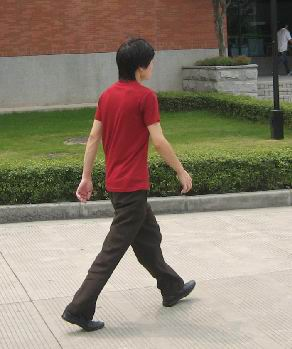

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

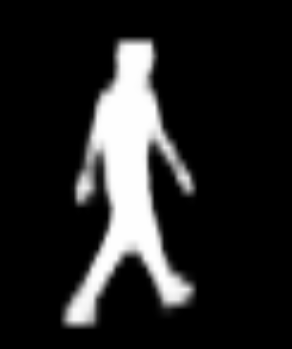

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection). 

